In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from numpy import sqrt
import time
from scipy import integrate

import sys
import os
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem

import pickle

import capytaine as cpt
# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)
import copy

from capytaine_generator import CapytaineSlantSolver

In [ ]:
css = CapytaineSlantSolver(True, True, True, True, True)

h = 50
a = [4, 9]
d_in = [29, 7.5]
d_out = [29, 2.5]
heaving = [0, 1]
m0 = 1
rho = 1023

t_densities = [50, 80]
face_units = 100 # filler
f_densities = [15, 60, 30, 15]

respack = css.construct_and_solve(a, d_in, d_out, heaving, t_densities, 10, h, m0, rho, 1, f_densities)
rad_result = respack[0]

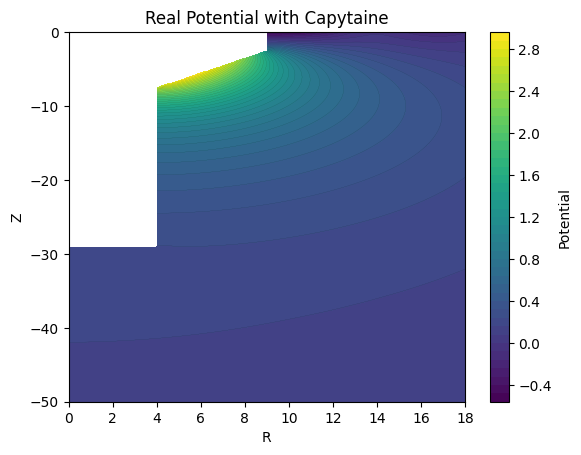

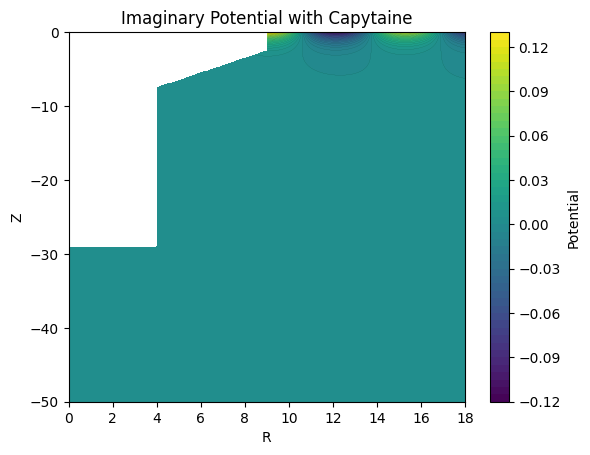

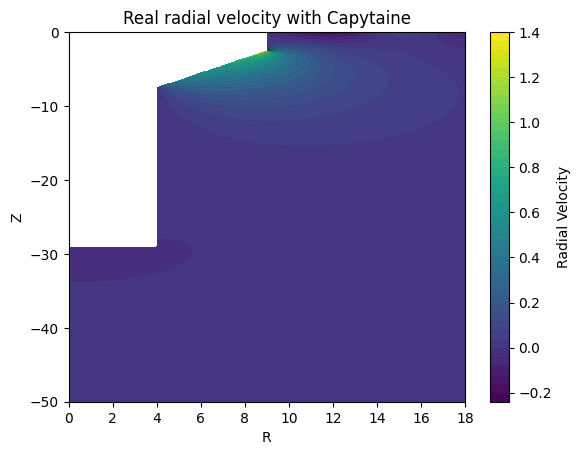

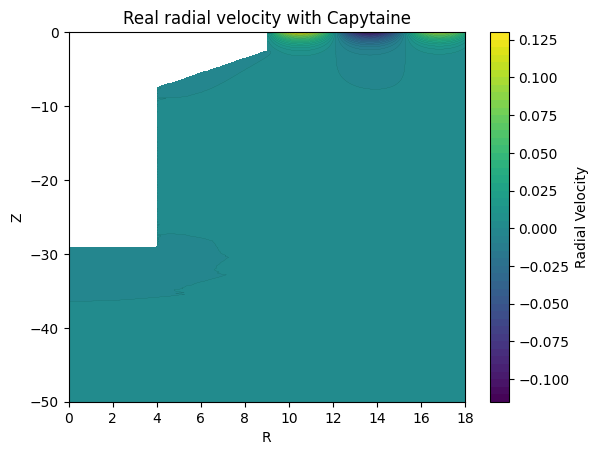

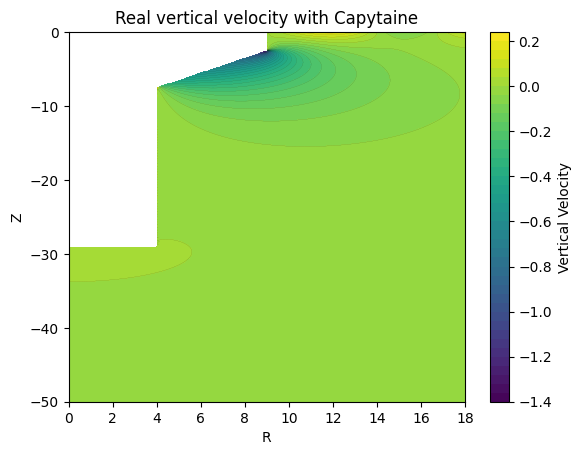

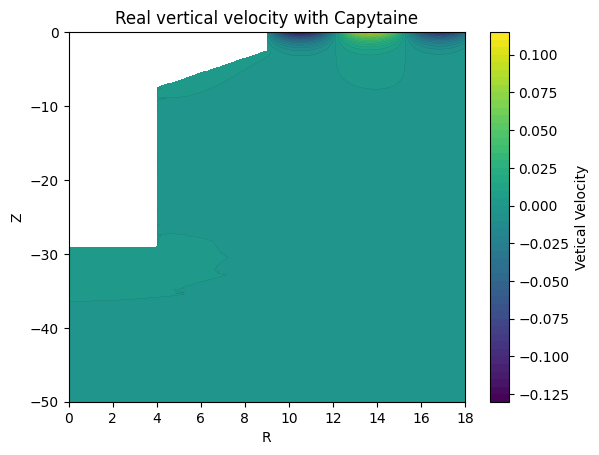

In [14]:
res = 400
pot_pack = css.plot_potential(h, a, d_in, d_out, res, rad_result, True)
vel_pack = css.plot_velocities(h, a, d_in, d_out, res, rad_result, True)

In [4]:
# Constants
h = 50
d = [29, 7, 6, 5, 4, 3]
a = [4, 5, 6, 7, 8, 9]
heaving = [0, 1, 1, 1, 1, 1]
# 0/false if not heaving, 1/true if yes heaving
NMK = [100] * 7 # Number of terms in approximation of each region (including e).
# All computations assume at least 2 regions.

m0 = 1
g = 9.81
rho = 1023
prob = Problem(h, d, a, heaving, NMK, m0, rho)

In [5]:
a_matrix = prob.a_matrix()
b_vector = prob.b_vector()
x = prob.get_unknown_coeffs(a_matrix, b_vector)
cs = prob.reformat_coeffs(x)
am, dp = prob.hydro_coeffs(x, "capytaine")
print("Added Mass: " + str(am))
print("Damping: " + str(dp))
print("Excitation Phase: " + str(prob.excitation_phase(x)))

Added Mass: 577431.8306882913
Damping: 802.3738694474861
Excitation Phase: -1.97366434550881


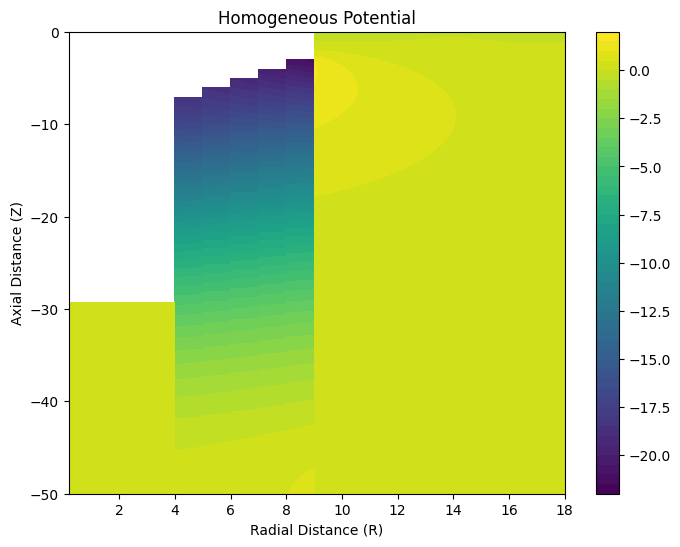

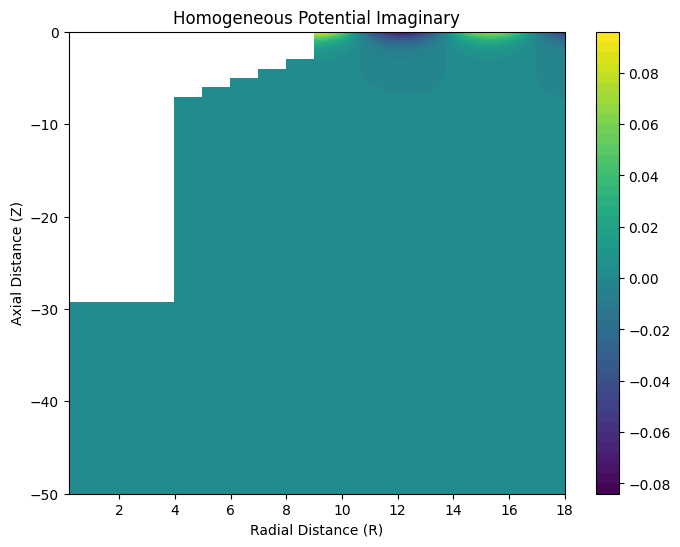

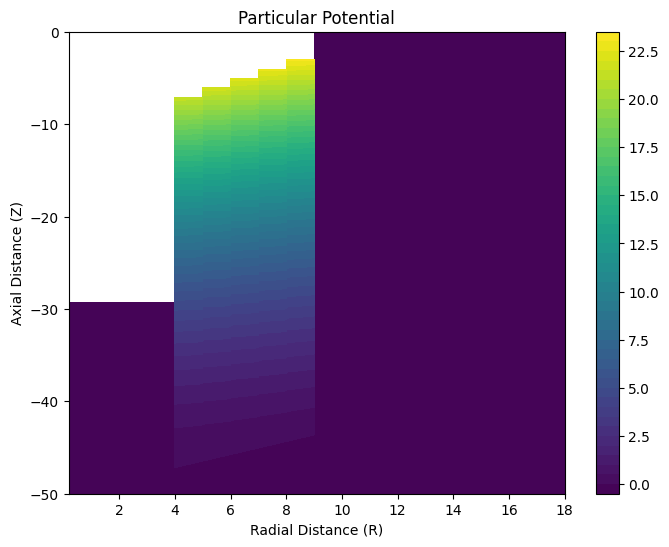

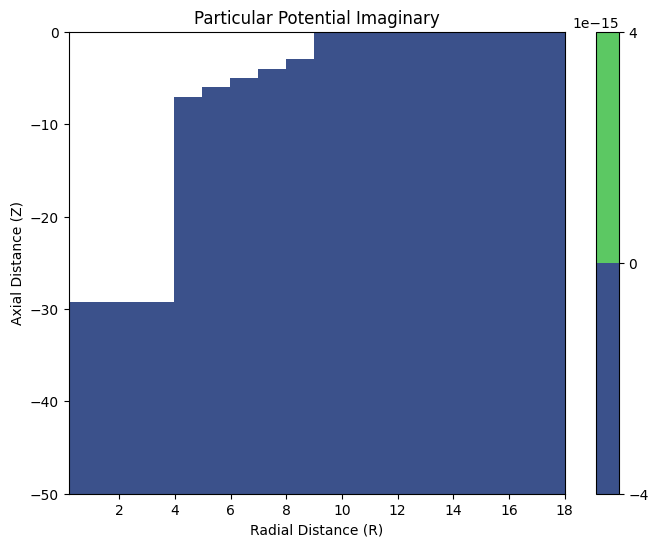

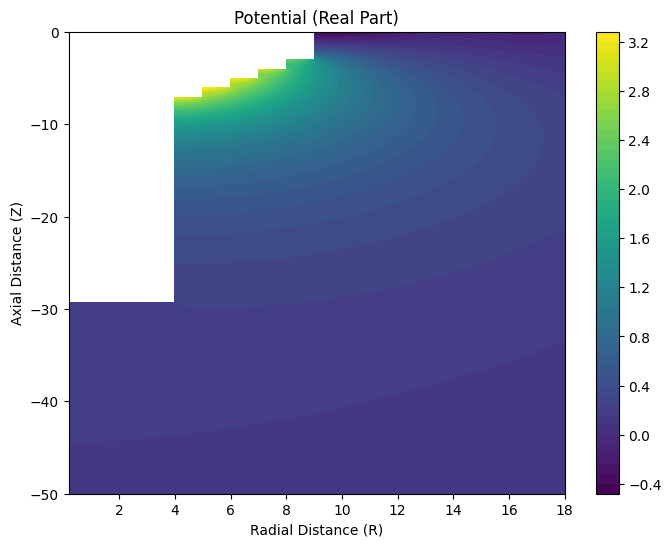

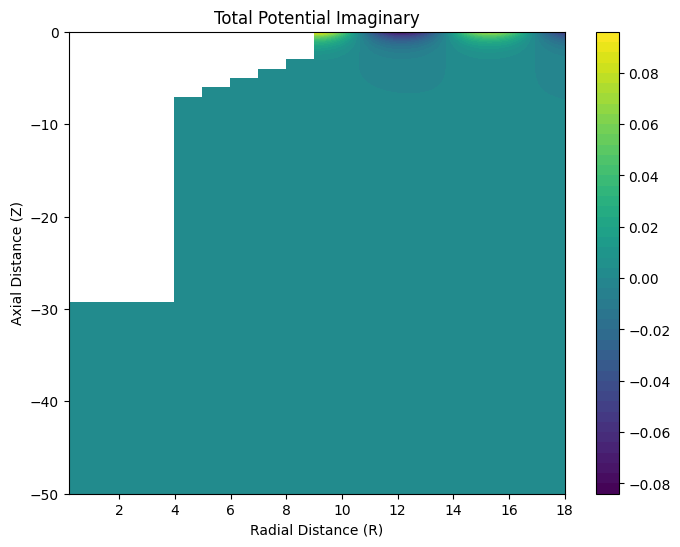

In [6]:
prob.plot_potentials(cs, res)

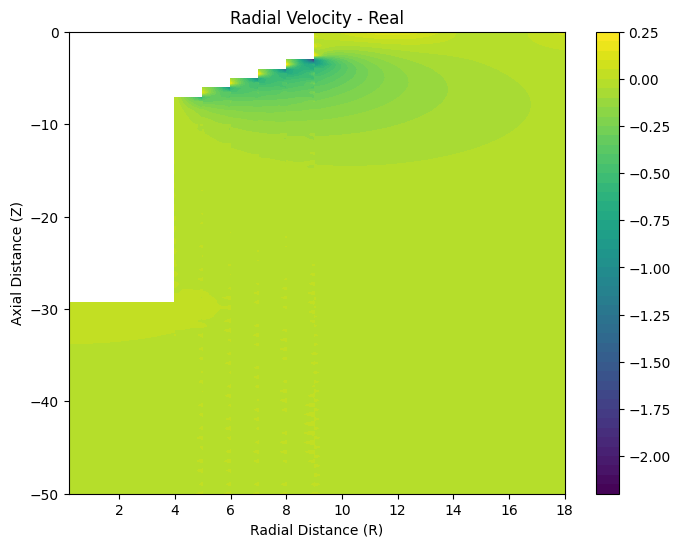

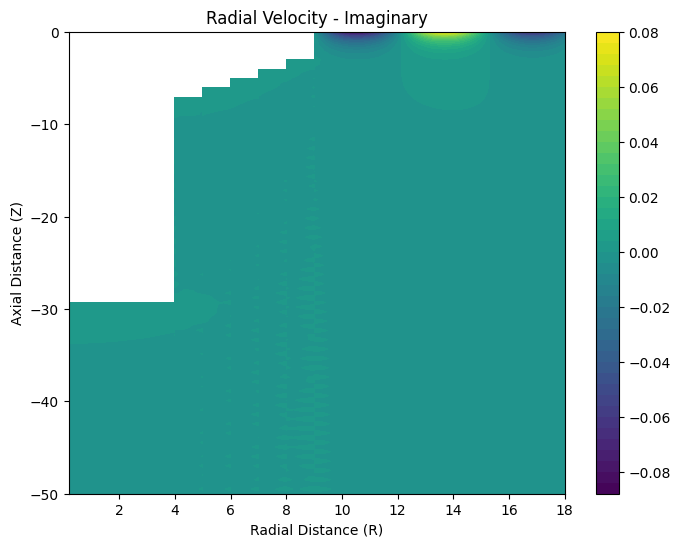

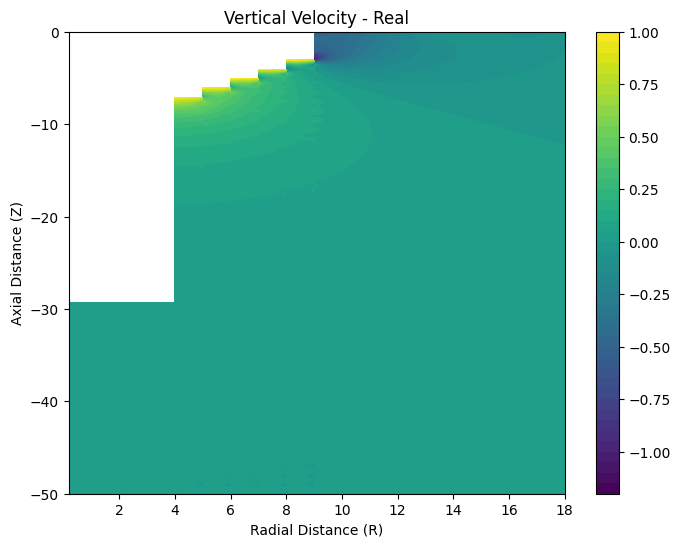

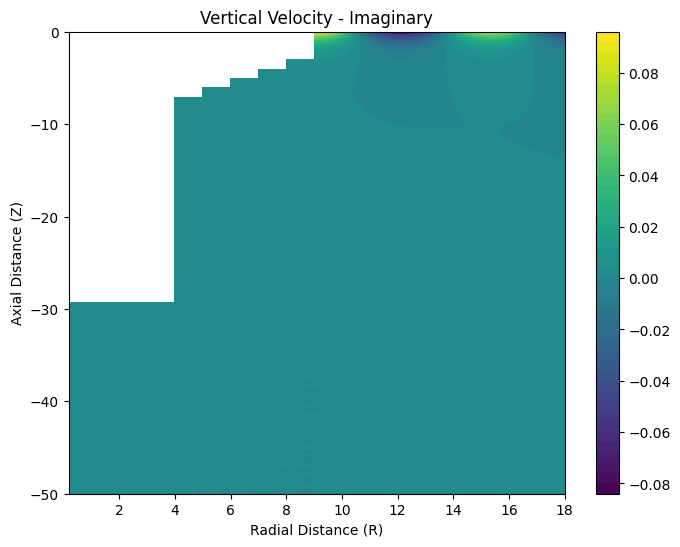

In [7]:
prob.plot_velocities(cs, res)

In [19]:
R, Z, phi, nanregions = prob.config_potential_array(cs, 400)

In [26]:
def plot_comparison(field, title, color):
    plt.figure(figsize=(8, 6))
    plt.contourf(R, Z, field, levels=50, cmap = color)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

# arguments: the name of the csv to compare with, an appropriately formatted potential array
# the threshold of closeness, appropriate R and Z, and omega to help with conversion
# tailored for 50x50 points (including nans), evenly spaced, twice the widest radius, and given height

def potential_comparison(p_real_cpt, p_imag_cpt, p_real_meem, p_imag_meem):

  R, Z = prob.make_R_Z(False, 400)

  plot_comparison(p_real_cpt, 'Capytaine Potential Real', "viridis")
  plot_comparison(p_real_meem, 'MEEM Potential Real', "viridis")
  plot_comparison(p_imag_cpt, 'Capytaine Potential Imaginary', "viridis")
  plot_comparison(p_imag_meem, 'MEEM Potential Imaginary', "viridis")

  meem_minus_cpt_real = p_real_meem - p_real_cpt
  meem_minus_cpt_imag = p_imag_meem - p_imag_cpt

  plot_comparison(meem_minus_cpt_real, 'Real Potential Difference', "plasma")
  plot_comparison(meem_minus_cpt_imag, 'Imag Potential Difference', "plasma")

  raw_fraction_real = (meem_minus_cpt_real)/p_real_cpt
  raw_fraction_imag = (meem_minus_cpt_imag)/p_imag_cpt

  fraction_real = classify_with_sign(raw_fraction_real)
  fraction_imag = np.where(abs(raw_fraction_imag) < 1, raw_fraction_imag, 2)

  plot_comparison(raw_fraction_real, 'Fractional Real Potential Difference', "plasma")
  plot_comparison(raw_fraction_imag, 'Fractional Imag Potential Difference', "plasma")
  plot_comparison(fraction_real, 'Fractional Real Potential Difference', "plasma")
  plot_comparison(fraction_imag, 'Fractional Imag Potential Difference', "plasma")

def replace_large_values(arr):
    return np.where(
        np.isnan(arr),           # Condition 1: keep NaNs
        np.nan,                  # Keep original NaN
        np.where(
            np.abs(arr) >= 0.1,  # Condition 2: replace large values
            0.2,                 # Replacement value
            arr                  # Keep small values
        )
    )


def classify_with_sign(arr):
    result = np.full_like(arr, np.nan, dtype=float)

    not_nan = ~np.isnan(arr)
    abs_arr = np.abs(arr[not_nan])
    signs = np.sign(arr[not_nan])

    # Build categories
    categories = np.zeros_like(abs_arr, dtype=int)
    categories[abs_arr >= 0.1] = 3
    categories[(abs_arr >= 0.05) & (abs_arr < 0.1)] = 2
    categories[(abs_arr >= 0.01) & (abs_arr < 0.05)] = 1
    categories[(abs_arr > 0.0) & (abs_arr < 0.01)] = 0
    categories[arr[not_nan] == 0.0] = 0  # explicitly handle zero

    # Reapply signs
    result[not_nan] = signs * categories

    return result

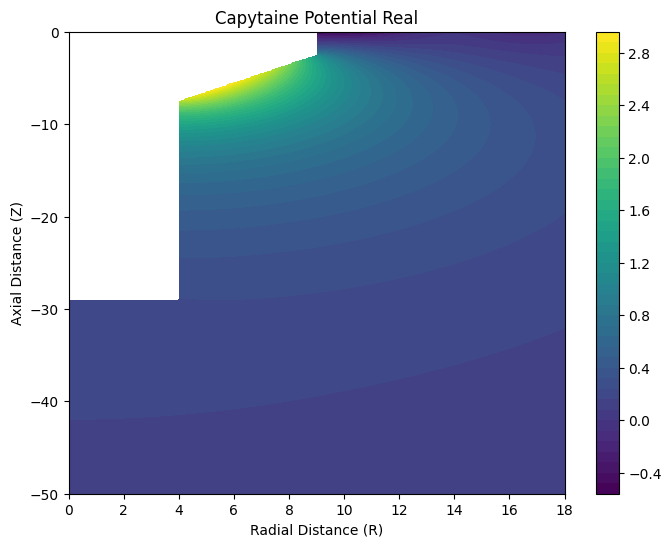

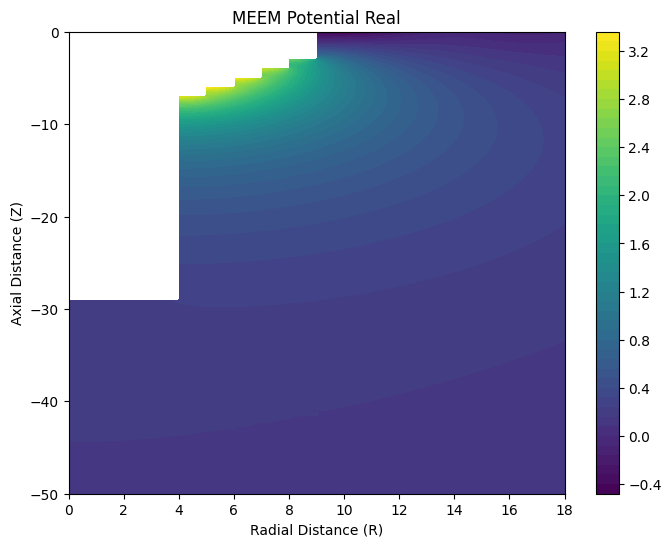

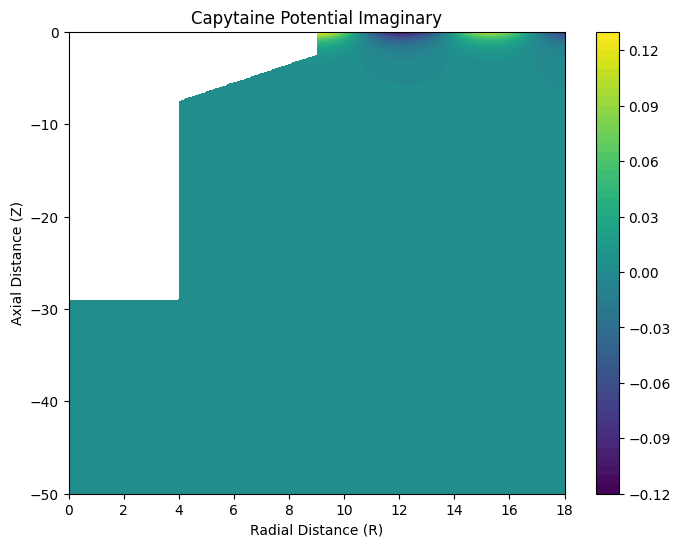

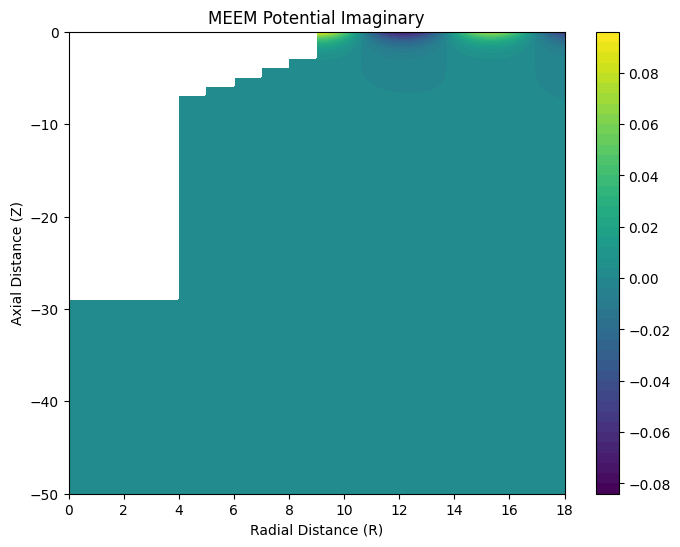

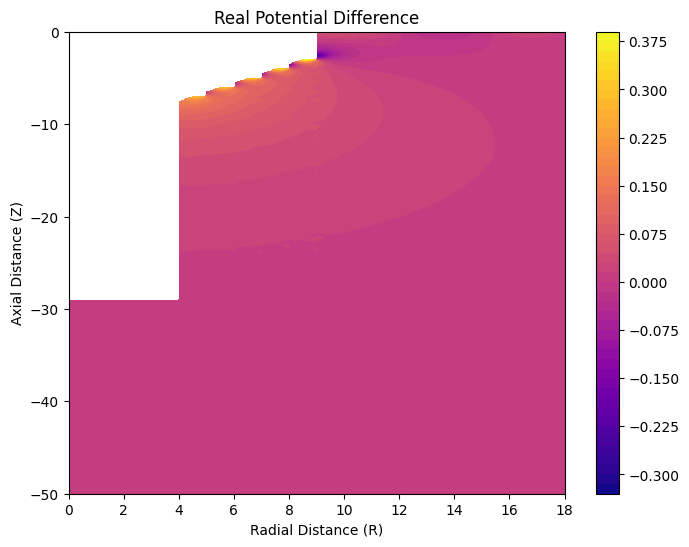

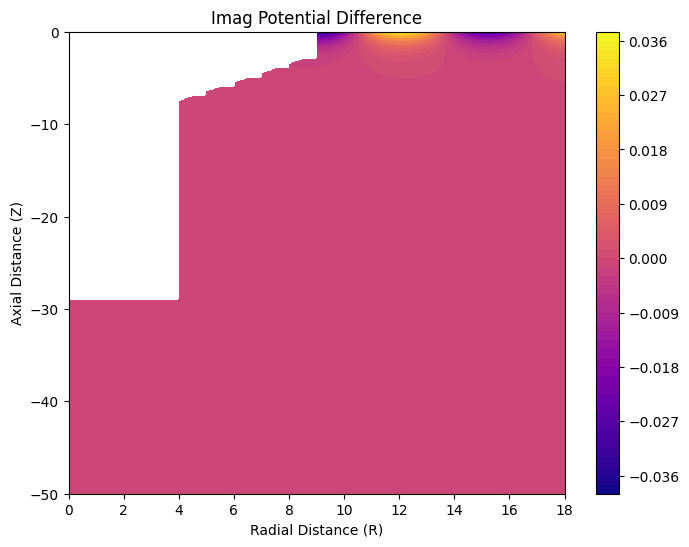

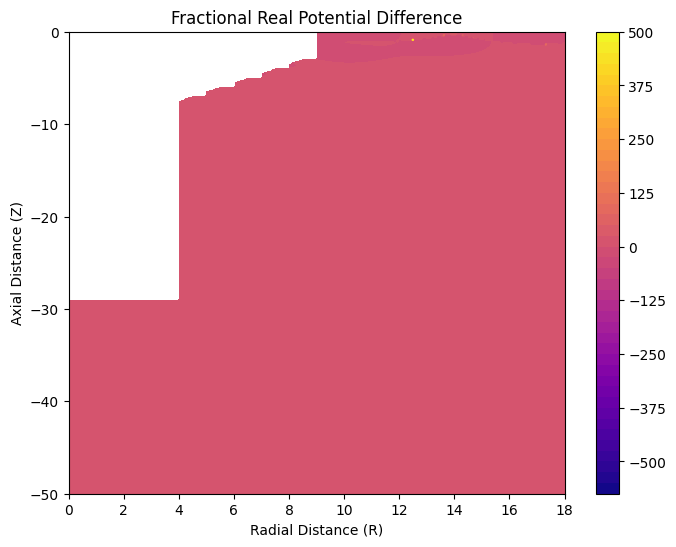

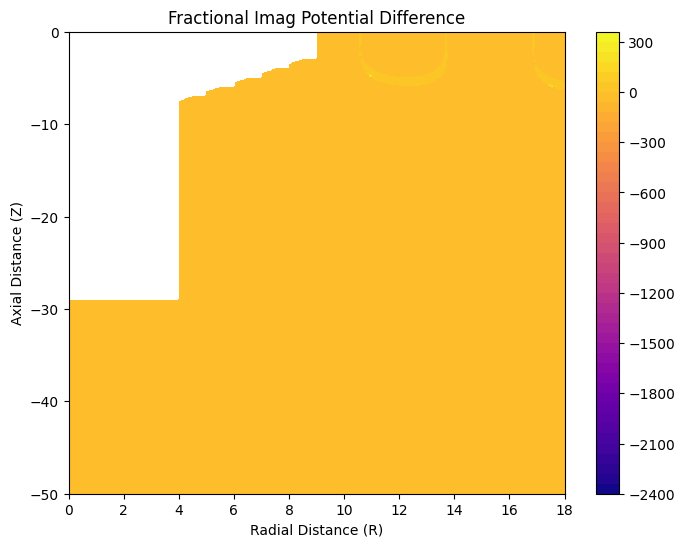

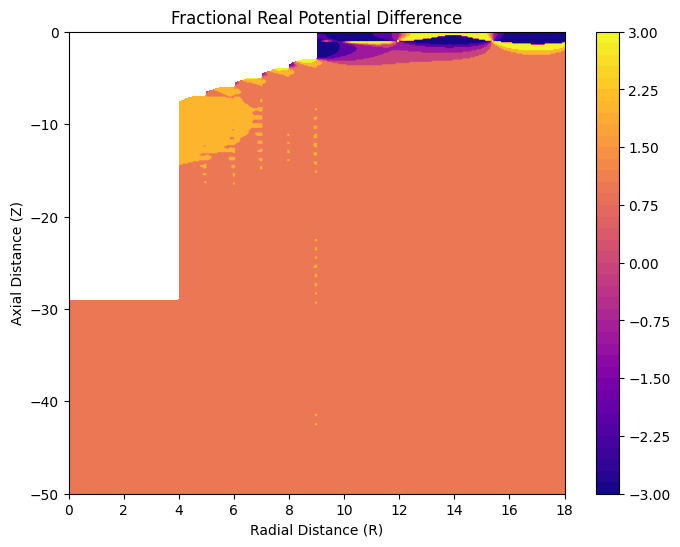

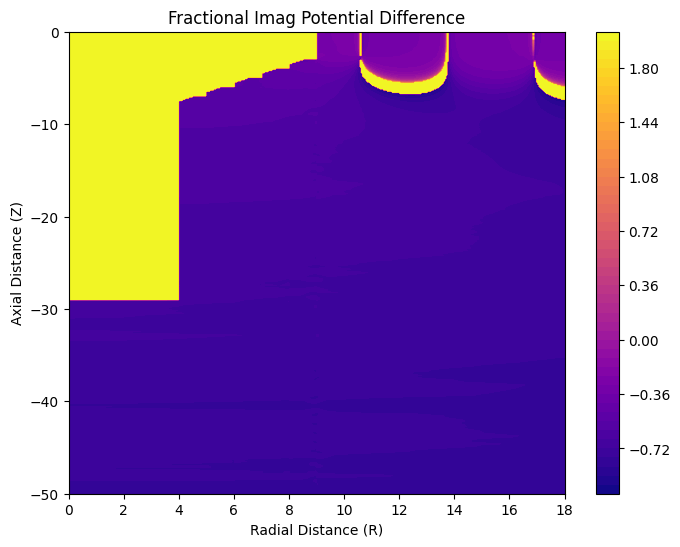

In [27]:
potential_comparison(pot_pack[0], pot_pack[1], np.real(phi), np.imag(phi))